In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none' # fonts as fonts
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]

import hddm
print(hddm.__version__)

import os

# use scour library to clean SVGs
def scourfig(file):
    os.system('cp '+file+' temp.svg')
    os.system('scour -i temp.svg -o '+file+' --enable-viewboxing --enable-id-stripping \
    --enable-comment-stripping --shorten-ids --indent=none')
    os.remove('temp.svg')

0.9.6


In [2]:
df = pd.concat((pd.read_csv('../Learning/JKchoice.csv', index_col=0), 
                pd.read_csv('../Learning/BGMVchoice.csv', index_col=0)))

In [3]:
# Latency (90%)  -- use to screen out trials unusually long response latencies
Latency_cutoff = df.choice.quantile(0.95).round()
print(Latency_cutoff)

2.0


In [4]:
# ITI (90%)  -- use to screen out trials after unusually long breaks
ITI_cutoff = df.iti.quantile(0.95).round()
print(ITI_cutoff)

40.0


In [5]:
df = df[(df.choice<Latency_cutoff) & (df.iti>0) & (df.iti<ITI_cutoff)]
df.reset_index(inplace=True) 
df.drop(columns=['index'], inplace=True)
df.shape

(18860, 14)

In [6]:
# drop single offer trials
df = df[df.trialtype==1]

In [7]:
# renaming name, latency, and choice columns to match that of HDDM tutorial
df = df.rename(columns={"name": "subj_idx", "choice": "rt", "sucrose": "response"})

# changing high/low suc to values to match expected column names for HDDM
df['response'] = np.where(df['response'] == 4, 0, 1) # choosing low = 0, high = 1

In [8]:
df.subj_idx = df.subj_idx.astype(str)
df.subj_idx.unique()

array(['JK07', 'JK08', 'JK09', 'JK03', 'JK12', 'MV01', 'MV06', 'MV03',
       'MV04', 'BG06', 'BG11', 'BG01', 'BG08', 'BG03', 'BG04', 'BG12',
       'BG02', 'BG05'], dtype=object)

In [9]:
df.head()

,subj_idx,date,session,time,trialtype,cue,response,side,error,rt,reward,iti,sex,sess
2,JK07,03-15,choice,34.608,1,8,1,1,0,0.810,1.068,9.676,1,1
8,JK07,03-15,choice,75.584,1,2,0,0,0,0.548,1.034,6.590,1,1
10,JK07,03-15,choice,90.638,1,8,1,1,0,0.356,1.386,6.430,1,1
13,JK07,03-15,choice,114.994,1,8,1,0,0,0.858,0.824,7.582,1,1
14,JK07,03-15,choice,121.218,1,8,1,1,0,0.484,1.178,6.224,1,1


In [10]:
males = df[df.sex==1]
males.reset_index(drop=True, inplace=True)
females = df[df.sex==0]
females.reset_index(drop=True, inplace=True)

### build DDM and simulate data from males and females

#### Posterior Predictive Checks: summary statistics

Reference:  https://doi.org/10.1111/ejn.14890  

_Supplementary Table 1. Summary statistics of the posterior predictive checks in Experiment 1. The first
and second columns represent the observed and simulated mean values for each measure indicated by the
row name. The upper boundary represents correct responses while the lower boundary represents
incorrect responses. STD is a measure of how much variation is produced in the summary statistics. The
rest of the columns are various measures of the extent of deviation between the simulated and the
observed data (SEM is the standard error from the mean, MSE is the mean-squared error)._

The key metric is the column "credible", i.e., observed and simulated data are within the 95% CI for each statistic.

From Michael Frank (https://groups.google.com/g/hddm-users/c/MarwmUlHKqs/m/j-_CZGq4DgAJ):  
_"SEM is calculated as just the squared difference between the mean observed data and the mean of simulated data sets, which is an unsigned measure of how far the overall means are from each other, but is not SEM"_

from the source code:  
```
evals["SEM"] = lambda x, y: (np.mean(x) - y) ** 2
```


**males**

In [11]:
data_males = hddm.utils.flip_errors(males)

In [12]:
m_males = hddm.HDDM(data_males, is_group_model=True, bias=False)
m_males.find_starting_values()
m_males.sample(5000, burn=2500)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 190.0 sec

In [13]:
stats_males = m_males.gen_stats()
stats_males[stats_males.index.isin(['a', 'v', 't', 'z'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.522131,0.067992,1.401125,1.479213,1.518646,1.56154,1.666698,0.001604
v,0.81837,0.106654,0.61346,0.757073,0.821566,0.877834,1.012564,0.002342
t,0.279553,0.02413,0.237708,0.264601,0.277373,0.291829,0.332921,0.000753


In [14]:
ppc_males = hddm.utils.post_pred_gen(m_males)

 [-------------------111%-------------------] 10 of 9 complete in 42.7 sec

In [15]:
hddm.utils.post_pred_stats(data_males, ppc_males)

,observed,mean,std,SEM,MSE,credible,quantile,mahalanobis
stat,,,,,,,,
accuracy,0.769399,0.771992,0.066732,6.723545e-06,0.004460,True,45.155556,0.038857
mean_ub,0.725042,0.808145,0.127420,6.906165e-03,0.023142,True,26.488890,0.652202
std_ub,0.354891,0.421684,0.090954,4.461294e-03,0.012734,True,28.866667,0.734359
10q_ub,0.364000,0.423759,0.063554,3.571101e-03,0.007610,True,12.844444,0.940285
30q_ub,0.492000,0.541265,0.081558,2.427000e-03,0.009079,True,26.933332,0.604044
50q_ub,0.630000,0.684677,0.107106,2.989523e-03,0.014461,True,32.022221,0.510489
70q_ub,0.820000,0.897714,0.147402,6.039459e-03,0.027767,True,33.222221,0.527223
90q_ub,1.230000,1.353105,0.238775,1.515474e-02,0.072168,True,35.444443,0.515567
mean_lb,-0.826306,-0.806422,0.132242,3.953930e-04,0.017883,True,46.822224,0.150365


In [16]:
ppc_stats_males = hddm.utils.post_pred_stats(data_males, ppc_males)

In [17]:
ppc_stats_males.to_csv('ppc_stats_males_fixedbias_240521.csv')

**females**

In [18]:
data_females = hddm.utils.flip_errors(females)

In [19]:
m_females = hddm.HDDM(data_females, is_group_model=True, bias=False)
m_females.find_starting_values()
m_females.sample(5000, burn=2500)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 179.0 sec

In [20]:
stats_females = m_females.gen_stats()
stats_females[stats_females.index.isin(['a', 'v', 't', 'z'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.548748,0.054731,1.447091,1.514534,1.547272,1.579314,1.662923,0.001265
v,1.26343,0.091243,1.085817,1.206056,1.264317,1.319068,1.450964,0.002052
t,0.216916,0.008123,0.200841,0.212144,0.216894,0.221638,0.233632,0.00019


In [21]:
ppc_females = hddm.utils.post_pred_gen(m_females)

 [-------------------111%-------------------] 10 of 9 complete in 36.6 sec

In [22]:
hddm.utils.post_pred_stats(data_females, ppc_females)

,observed,mean,std,SEM,MSE,credible,quantile,mahalanobis
stat,,,,,,,,
accuracy,0.861142,0.874794,0.046328,0.000186,0.002333,True,33.955555,0.294684
mean_ub,0.666927,0.690571,0.056089,0.000559,0.003705,True,33.422222,0.421531
std_ub,0.357994,0.361594,0.051980,0.000013,0.002715,True,52.400002,0.069259
10q_ub,0.350000,0.358391,0.020052,0.000070,0.000472,True,31.288889,0.418485
30q_ub,0.428000,0.462502,0.029917,0.001190,0.002085,True,12.622222,1.153266
50q_ub,0.538000,0.586252,0.044425,0.002328,0.004302,True,12.533334,1.086137
70q_ub,0.740000,0.769148,0.068323,0.000850,0.005518,True,34.177776,0.426622
90q_ub,1.200400,1.159108,0.123949,0.001705,0.017068,True,66.222221,0.333135
mean_lb,-0.802539,-0.691914,0.073400,0.012238,0.017625,True,7.955555,1.507151


In [23]:
ppc_stats_females = hddm.utils.post_pred_stats(data_females, ppc_females)

In [24]:
ppc_stats_females.to_csv('ppc_stats_females_fixedbias_240521.csv')

**compare squared difference between the means of the observed and simulated data**

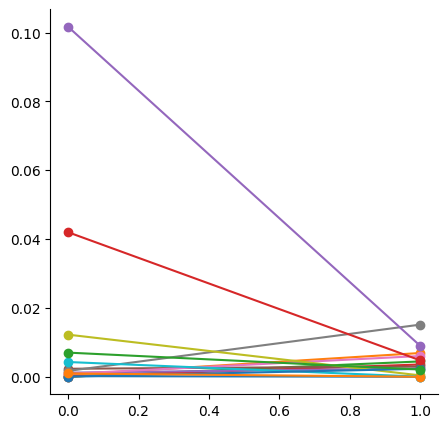

In [25]:
plt.plot([0,1],[ppc_stats_females.SEM,ppc_stats_males.SEM],'o-')
sns.despine()

In [26]:
from scipy import stats

In [27]:
stats.ttest_rel(ppc_stats_females.SEM,ppc_stats_males.SEM)

Ttest_relResult(statistic=1.1359192714431392, pvalue=0.2750623330471247)

**posteriors**

https://github.com/psychNerdJae/hddm_tutorial/blob/main/hddm_tutorial_2022.ipynb  

Jae-Young Son, based on this paper: https://doi.org/10.1038/s41598-019-48050-2  

Plotting v
Scour processed file "temp.svg" in 102 ms: 49301/95041 bytes new/orig -> 51.9%


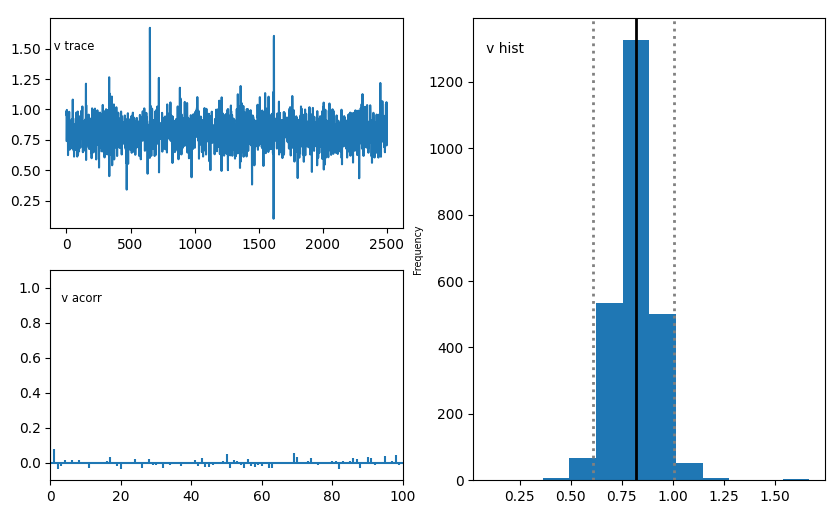

In [28]:
m_males.plot_posteriors(['v'])
plt.savefig('posteriors_males_v_240521.svg')
scourfig('posteriors_males_v_240521.svg')

Plotting v
Scour processed file "temp.svg" in 120 ms: 49248/94851 bytes new/orig -> 51.9%


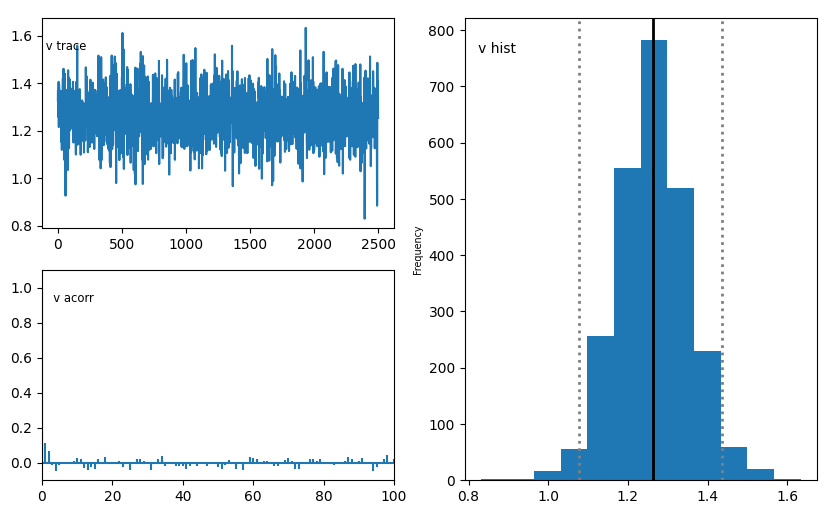

In [29]:
m_females.plot_posteriors(['v'])
plt.savefig('posteriors_females_v_240521.svg')
scourfig('posteriors_females_v_240521.svg')

Plotting a
Scour processed file "temp.svg" in 112 ms: 48999/94207 bytes new/orig -> 52.0%


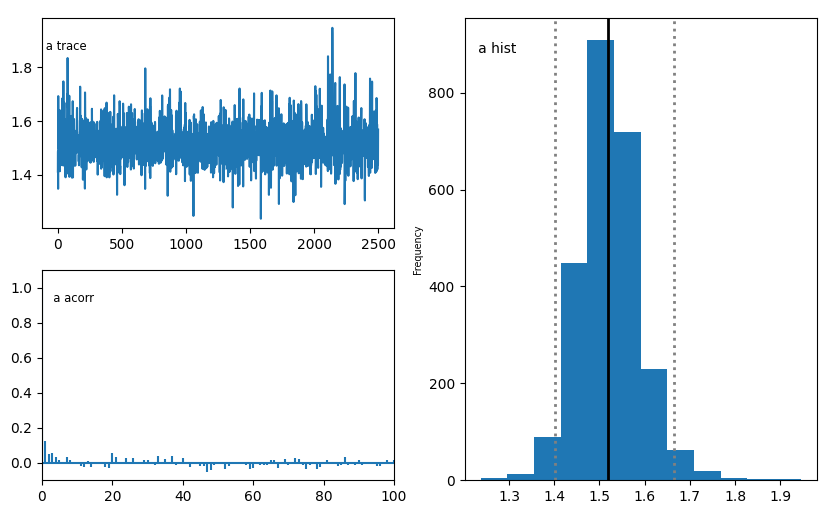

In [30]:
m_males.plot_posteriors(['a'])
plt.savefig('posteriors_males_a_240521.svg')
scourfig('posteriors_males_a_240521.svg')

Plotting a
Scour processed file "temp.svg" in 114 ms: 49251/94951 bytes new/orig -> 51.9%


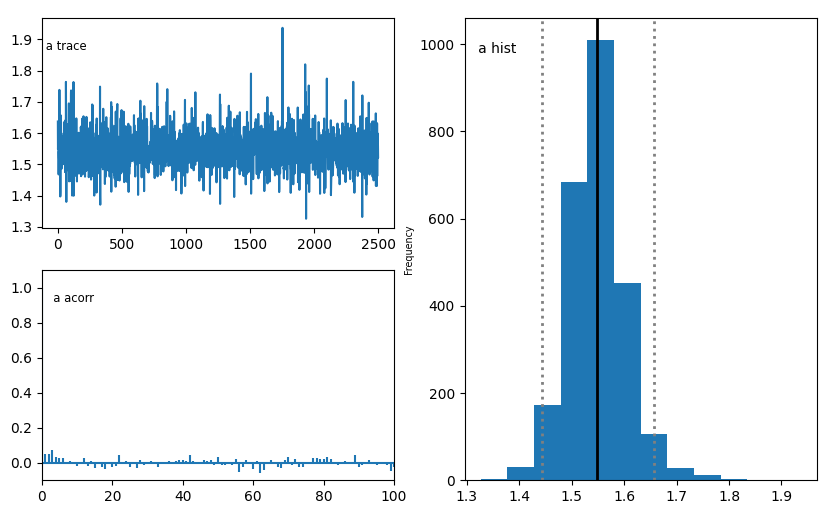

In [31]:
m_females.plot_posteriors(['a'])
plt.savefig('posteriors_females_a_240521.svg')
scourfig('posteriors_females_a_240521.svg')

Plotting t
Scour processed file "temp.svg" in 115 ms: 48798/94163 bytes new/orig -> 51.8%


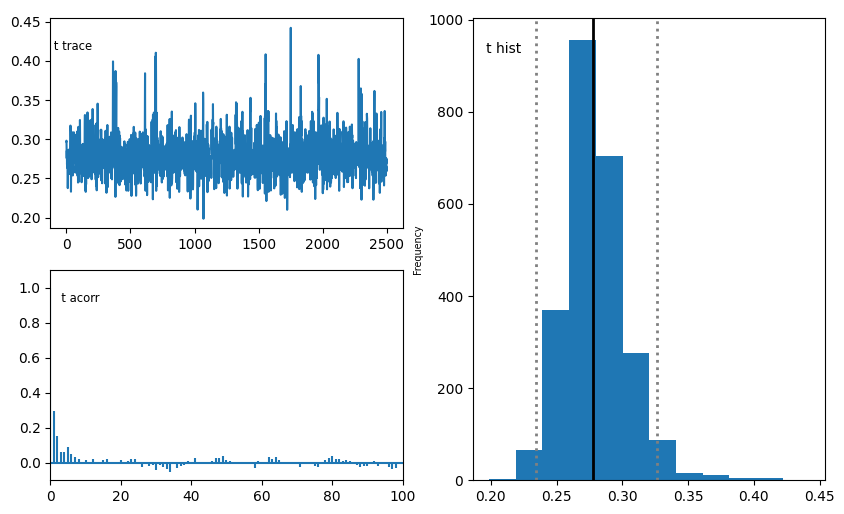

In [32]:
m_males.plot_posteriors(['t'])
plt.savefig('posteriors_males_t_240521.svg')
scourfig('posteriors_males_t_240521.svg')

Plotting t
Scour processed file "temp.svg" in 116 ms: 48619/93781 bytes new/orig -> 51.8%


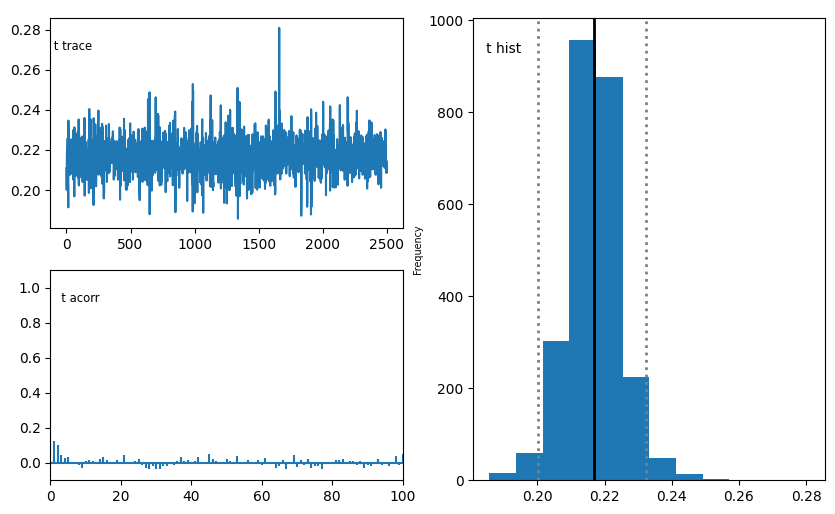

In [33]:
m_females.plot_posteriors(['t'])
plt.savefig('posteriors_females_t_240521.svg')
scourfig('posteriors_females_t_240521.svg')

### posterior predictive plots

the code below plots posterior predictives derived from actual simulation runs from the model

https://hddm.readthedocs.io/en/latest/lan_visualizations.html  

_note that the plotting routines below do not work with standard matplotlib commands for saving the figure_

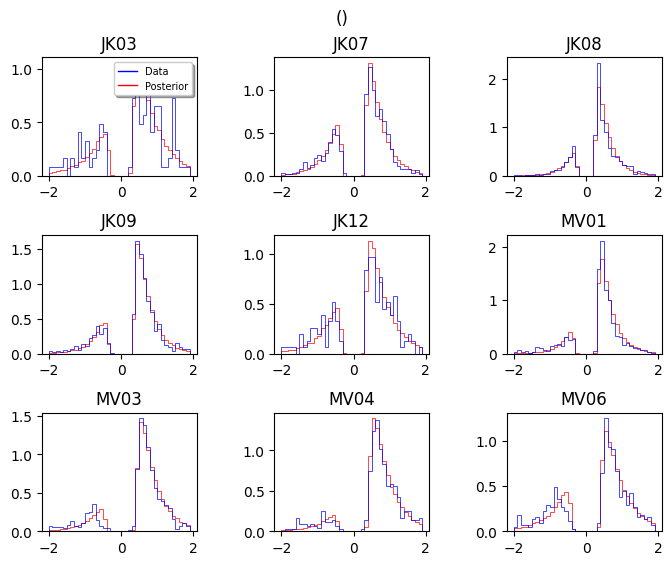

In [44]:
hddm.plotting.plot_posterior_predictive(model=m_males, columns=3,
                                        value_range = np.arange(-2, 2, 0.02),
                                        plot_func = hddm.plotting._plot_func_posterior_node_from_sim,
                                        parameter_recovery_mode = True,
                                        save=True, format='svg',
                                        **{'alpha': 0.01,
                                           'ylim': 3,
                                           'bin_size': 0.1,
                                           'add_posterior_mean_rts': True,
                                           'add_posterior_uncertainty_rts': False,
                                           'samples': 200,
                                           'legend_fontsize': 7,
                                           'subplots_adjust': {'top': 0.9, 'hspace': 0.5, 'wspace': 0.5}})

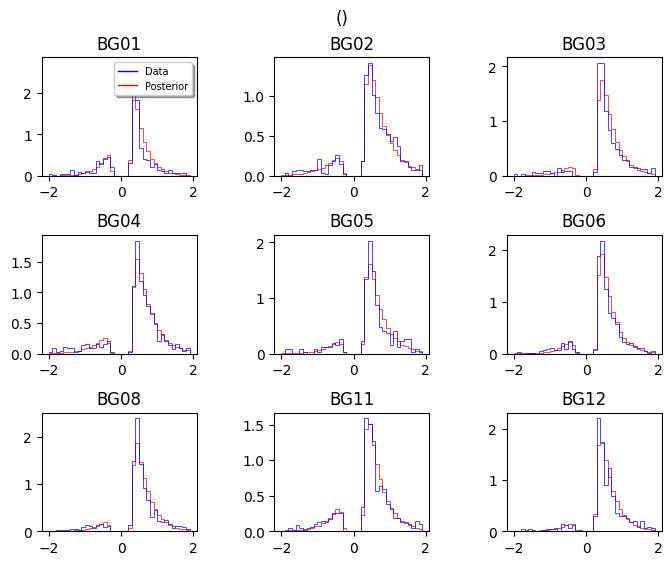

In [35]:
hddm.plotting.plot_posterior_predictive(model=m_females, columns=3,
                                        value_range = np.arange(-2, 2, 0.02),
                                        plot_func = hddm.plotting._plot_func_posterior_node_from_sim,
                                        parameter_recovery_mode = True,
                                        save=True, format='svg',
                                        **{'alpha': 0.01,
                                           'ylim': 3,
                                           'bin_size': 0.1,
                                           'add_posterior_mean_rts': True,
                                           'add_posterior_uncertainty_rts': False,
                                           'samples': 200,
                                           'legend_fontsize': 7,
                                           'subplots_adjust': {'top': 0.9, 'hspace': 0.5, 'wspace': 0.5}})

### jackratting the fits

In [63]:
a_males = []; v_males = []; t_males = []
for i in np.unique(males.subj_idx):
    
    temp = hddm.utils.flip_errors(males[males.subj_idx!=i])
    
    m_temp = hddm.HDDM(temp, is_group_model=True, bias=False)
    m_temp.find_starting_values()
    m_temp.sample(5000, burn=2500)
    
    stats_temp = m_temp.gen_stats()
    a_males.append(stats_temp[stats_temp.index.isin(['a'])]['mean'][0])
    v_males.append(stats_temp[stats_temp.index.isin(['v'])]['mean'][0])
    t_males.append(stats_temp[stats_temp.index.isin(['t'])]['mean'][0])

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 170.6 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 164.1 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 157.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 160.0 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 169.3 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 162.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 162.4 secNo model attr

In [64]:
a_females = []; v_females = []; t_females = []
for i in np.unique(females.subj_idx):
    
    temp = hddm.utils.flip_errors(females[females.subj_idx!=i])
    
    m_temp = hddm.HDDM(temp, is_group_model=True, bias=False)
    m_temp.find_starting_values()
    m_temp.sample(5000, burn=2500)
    
    stats_temp = m_temp.gen_stats()
    a_females.append(stats_temp[stats_temp.index.isin(['a'])]['mean'][0])
    v_females.append(stats_temp[stats_temp.index.isin(['v'])]['mean'][0])
    t_females.append(stats_temp[stats_temp.index.isin(['t'])]['mean'][0])

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 154.2 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 154.3 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 154.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 154.8 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 156.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 152.3 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5001 of 5000 complete in 155.9 secNo model attr

**threshold**

In [65]:
a_males

[1.5008758007517058,
 1.5402860894807022,
 1.5479876155302827,
 1.5443146166643238,
 1.5205104648891876,
 1.541670276225541,
 1.5172154035157535,
 1.4983460930311627,
 1.51275918536229]

In [66]:
a_females

[1.5860473907882824,
 1.528842242596878,
 1.539225544872964,
 1.5489486830972377,
 1.543842881439616,
 1.5623789141197197,
 1.550169524391864,
 1.5560288731676775,
 1.5379063898069323]

**drift rate**

In [67]:
v_males

[0.8553427564822201,
 0.8533621114613601,
 0.7946664097795993,
 0.8119242467162816,
 0.8477028826240425,
 0.7851863969444132,
 0.7946651947460923,
 0.7817226161728557,
 0.8510234479099162]

In [68]:
v_females

[1.299640550826071,
 1.2859050392810467,
 1.2315208573248764,
 1.2818265969120057,
 1.2640361237018534,
 1.2403744407902133,
 1.2363763414673568,
 1.2893746994770623,
 1.2276538367562]

**NDT**

In [69]:
t_males

[0.2872978927591099,
 0.28153210480219476,
 0.2884315642803524,
 0.27619948277778933,
 0.28460496228124,
 0.28390057422805065,
 0.26968647526135353,
 0.27467955092029717,
 0.2739993096063654]

In [70]:
t_females

[0.21613651413475773,
 0.22045537607786322,
 0.21736657397121203,
 0.21436422832660781,
 0.21832329638337447,
 0.21373817791256805,
 0.2149463303859071,
 0.21820447514083893,
 0.22041563654764532]

**plots**

In [77]:
df_jackrat = pd.DataFrame({'Sex': np.concatenate([np.repeat('M',9), np.repeat('F',9)]),
                          'Drift Rate:': np.concatenate([v_males, v_females]),
                          'Threshold:': np.concatenate([a_males, a_females]),
                          'NDT:': np.concatenate([t_males, t_females]),
                          })

In [79]:
df_jackrat.head()

,Sex,Drift Rate:,Threshold:,NDT:
0,M,0.855343,1.500876,0.287298
1,M,0.853362,1.540286,0.281532
2,M,0.794666,1.547988,0.288432
3,M,0.811924,1.544315,0.276199
4,M,0.847703,1.520510,0.284605


In [81]:
# https://seaborn.pydata.org/examples/jitter_stripplot.html

# "Melt" the dataset to "long-form" or "tidy" representation
df_jackrat = df_jackrat.melt(id_vars="Sex", var_name="Parameter")

In [82]:
df_jackrat.head()

,Sex,Parameter,value
0,M,Drift Rate:,0.855343
1,M,Drift Rate:,0.853362
2,M,Drift Rate:,0.794666
3,M,Drift Rate:,0.811924
4,M,Drift Rate:,0.847703


In [101]:
import matplotlib.colors as mcolors

In [108]:
cdict = {'F': mcolors.TABLEAU_COLORS['tab:blue'], 'M': mcolors.TABLEAU_COLORS['tab:green']}

Scour processed file "temp.svg" in 34 ms: 10186/20578 bytes new/orig -> 49.5%


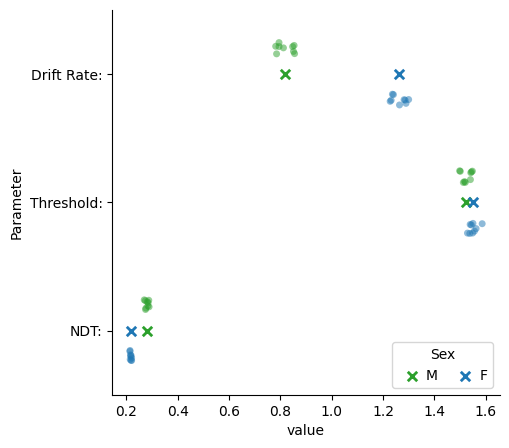

In [111]:
# Initialize the figure
f, ax = plt.subplots()
sns.despine() #bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=df_jackrat, x="value", y="Parameter", hue="Sex",
    dodge=True, alpha=.5, zorder=1, legend=False,
    palette=cdict,
)

# Show the conditional means
sns.pointplot(
    data=df_jackrat, x="value", y="Parameter", hue="Sex",
    errorbar=None, markers="x", linestyles="none",
    palette=cdict,
)

# Improve the legend
sns.move_legend(
    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0,
)

plt.savefig('Jackrat_DDM_params_240522.svg', dpi=300)
scourfig('Jackrat_DDM_params_240522.svg')

### Gelman-Rubin statistic

**males**

In [112]:
models = []
for i in range(5):
    m = hddm.HDDM(data_males, is_group_model=True, bias=False)
    m.find_starting_values()
    m.sample(5000, burn=2500)
    models.append(m)

hddm.analyze.gelman_rubin(models)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 184.1 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 185.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5001 of 5000 complete in 183.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 184.8 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 184.6 sec

{'a': 0.9999930759042027,
 'a_std': 1.000091877693176,
 'a_subj.JK03': 1.0002343997070589,
 'a_subj.JK07': 1.0004858715848666,
 'a_subj.JK08': 1.0000833309485904,
 'a_subj.JK09': 1.0000694825831642,
 'a_subj.JK12': 1.0000387643131536,
 'a_subj.MV01': 0.9999191839690142,
 'a_subj.MV03': 1.0002443198448985,
 'a_subj.MV04': 0.9999773692671563,
 'a_subj.MV06': 0.9999771354164104,
 'v': 0.9999113322660069,
 'v_std': 1.0000464393678092,
 'v_subj.JK03': 0.9999747683462763,
 'v_subj.JK07': 0.9998576628009812,
 'v_subj.JK08': 1.0003138461077277,
 'v_subj.JK09': 1.000195301023311,
 'v_subj.JK12': 1.0001526589885417,
 'v_subj.MV01': 1.0000481205185108,
 'v_subj.MV03': 0.9998403980814774,
 'v_subj.MV04': 0.9999827958957397,
 'v_subj.MV06': 1.0001368897564473,
 't': 1.0001094566256594,
 't_std': 1.000736211479362,
 't_subj.JK03': 1.0001203937749794,
 't_subj.JK07': 1.0009198440952034,
 't_subj.JK08': 0.9999913523065665,
 't_subj.JK09': 0.9998845024504296,
 't_subj.JK12': 1.0002452646485378,
 't_sub

In [113]:
GR_males = hddm.analyze.gelman_rubin(models)

In [117]:
models = []
for i in range(5):
    m = hddm.HDDM(data_females, is_group_model=True, bias=False)
    m.find_starting_values()
    m.sample(5000, burn=2500)
    models.append(m)

hddm.analyze.gelman_rubin(models)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 174.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 174.9 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 174.6 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 173.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 173.1 sec

{'a': 1.0000122058977423,
 'a_std': 1.0000009063590407,
 'a_subj.BG01': 1.00072802931743,
 'a_subj.BG02': 1.0004790502048617,
 'a_subj.BG03': 1.0002556963247944,
 'a_subj.BG04': 1.000288823239573,
 'a_subj.BG05': 1.0001769130053546,
 'a_subj.BG06': 1.00067348897537,
 'a_subj.BG08': 1.0003132131918557,
 'a_subj.BG11': 0.9999056085203082,
 'a_subj.BG12': 1.0017844460660643,
 'v': 0.999941282476656,
 'v_std': 1.000407287936894,
 'v_subj.BG01': 0.9999161640514158,
 'v_subj.BG02': 0.9998169859974576,
 'v_subj.BG03': 0.9999498188851147,
 'v_subj.BG04': 1.0003365578114412,
 'v_subj.BG05': 1.0001130798572566,
 'v_subj.BG06': 1.0002013629005766,
 'v_subj.BG08': 1.0005214314932491,
 'v_subj.BG11': 1.0000822625331414,
 'v_subj.BG12': 1.0002216580908316,
 't': 1.000207545664402,
 't_std': 1.000686009244957,
 't_subj.BG01': 1.0005193909685044,
 't_subj.BG02': 1.0004591236263498,
 't_subj.BG03': 1.0002405187909542,
 't_subj.BG04': 0.9999957428221959,
 't_subj.BG05': 0.9999470656434232,
 't_subj.BG06

In [118]:
GR_females = hddm.analyze.gelman_rubin(models)

In [119]:
GR_stats = pd.DataFrame({'Males': GR_males, 'Females': GR_females})

In [120]:
GR_stats.head()

,Males,Females
a,0.999993,1.000012
a_std,1.000092,1.000001
a_subj.JK03,1.000234,NaN
a_subj.JK07,1.000486,NaN
a_subj.JK08,1.000083,NaN


In [121]:
GR_stats.to_csv('GR_stats_BySex_240523.csv')